# Decision Tree on Smart Alert System

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from imblearn.over_sampling import SMOTE




## Process Data and Split

In [6]:
# Load the dataset
data_folder = Path.cwd() / "data"
csv_analysis = data_folder / "combinedAll.csv"
df = None
try:
    df = pd.read_csv(csv_analysis)
except FileNotFoundError as e:
    !wget -L https://raw.githubusercontent.com/KentvTran/Smart-Alert-Lab-ML/main/data/combinedAll.csv
    if not data_folder.exists():
        !mkdir data
    !mv combinedAll.csv data/combinedAll.csv
    df = pd.read_csv(csv_analysis)

# Aggregate the data by 5-second intervals
#Change interval to your desire
df['time_interval'] = (df['second'] - 1) // 5

aggregated_df = df.groupby('time_interval').agg({
    'distance': 'mean',
    'motion': 'mean',
    'lightIntensity': 'mean',
    'occupied': lambda x: x.mode().iloc[0],
    'occupied_note': lambda x: x.mode().iloc[0]
}).reset_index()

# Define features and target
X = aggregated_df[['distance', 'motion', 'lightIntensity', 'occupied']]
y = aggregated_df['occupied_note']

# Split into train and test sets (stratify ensures class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


## Decision Tree

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Best parameters: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 25, 'min_samples_split': 50}
Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.95      0.75      4703
         1.0       0.91      0.45      0.60      5090

    accuracy                           0.69      9793
   macro avg       0.77      0.70      0.68      9793
weighted avg       0.77      0.69      0.67      9793

Confusion Matrix:
[[4490  213]
 [2802 2288]]
ROC AUC Score: 0.80


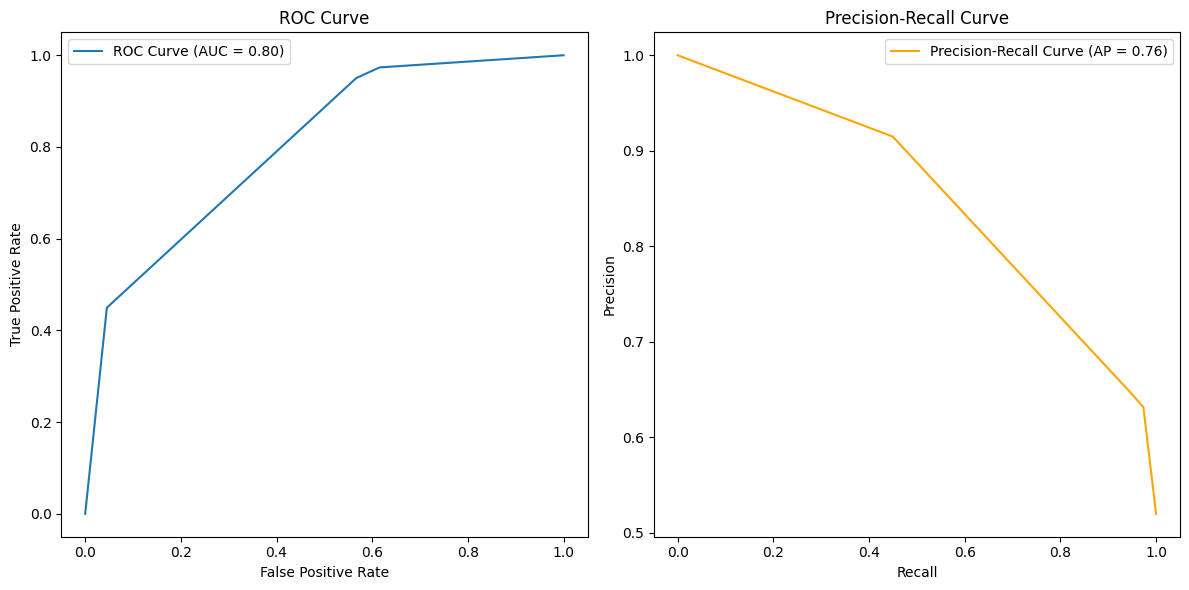

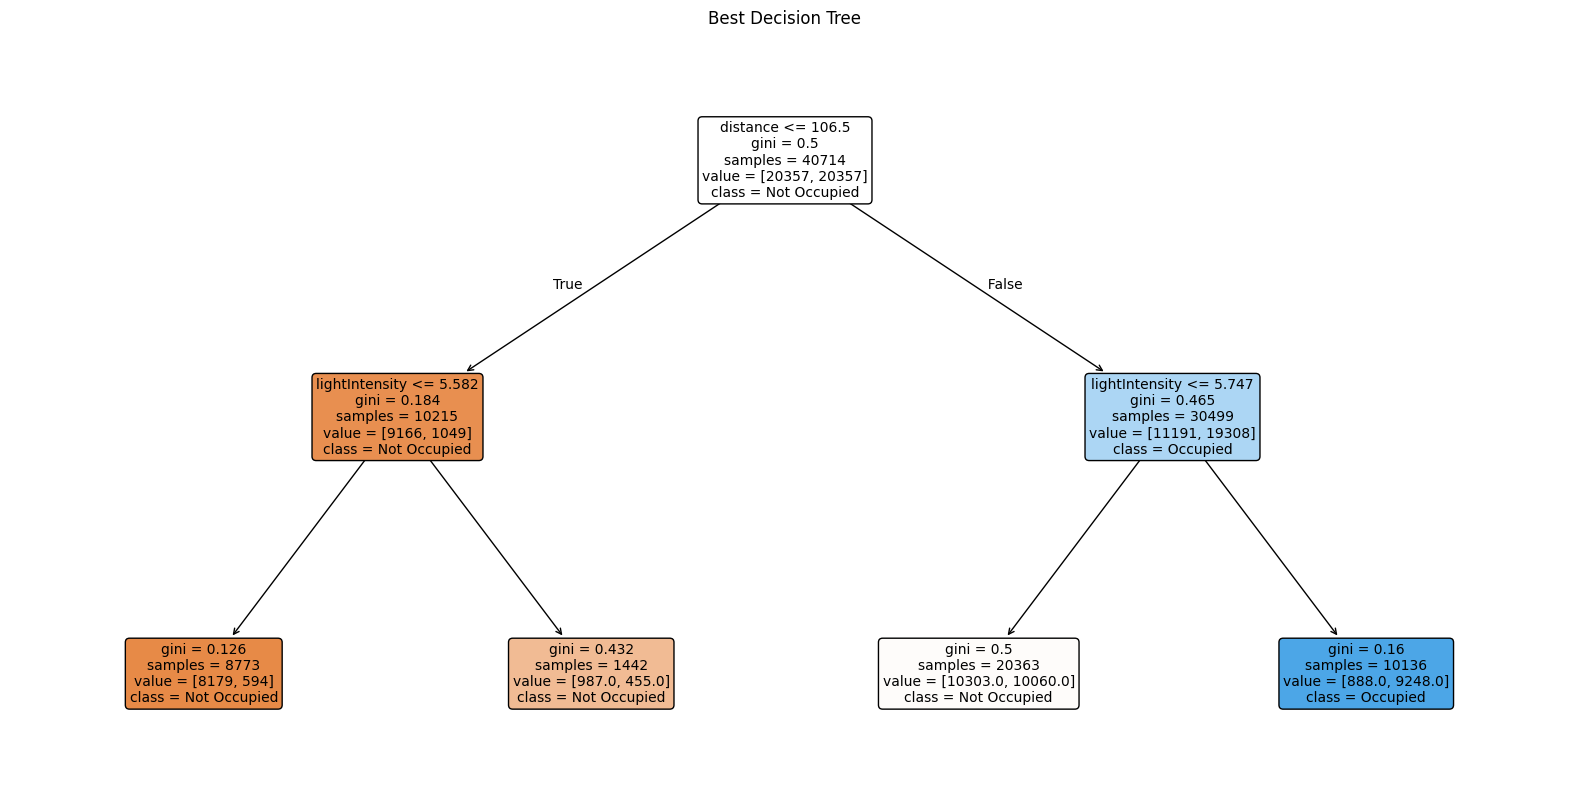

In [7]:
# Define parameter grid for tuning
param_grid = {
    'max_depth': [2, 3, 4, 5, 6],
    'min_samples_split': [50, 100, 500, 1000],
    'min_samples_leaf': [25, 50, 100, 200],
    'criterion': ['gini', 'entropy']
}

# Initialize Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Use GridSearchCV to find best parameters based on recall
grid_search = GridSearchCV(
    clf, param_grid, cv=5, scoring='precision', n_jobs=-1, verbose=1
)
grid_search.fit(X_train_smote, y_train_smote)

# Get best model
best_clf = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Train best model
best_clf.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred = best_clf.predict(X_test)
y_proba = best_clf.predict_proba(X_test)[:, 1]

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.2f}")

plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"Precision-Recall Curve (AP = {avg_precision:.2f})", color='orange')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    best_clf,
    feature_names=X_train_smote.columns if hasattr(X_train_smote, 'columns') else None,
    class_names=['Not Occupied', 'Occupied'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Best Decision Tree")
plt.show()

In [ ]:
import m2cgen as m2c

# Export the best model to C code.
c_code = m2c.export_to_c(best_clf)
print("Generated C Code:\n")
print(c_code)


Generated C Code:

#include <string.h>
void score(double * input, double * output) {
    double var0[2];
    if (input[0] <= 106.5) {
        if (input[2] <= 5.582000017166138) {
            memcpy(var0, (double[]){0.932292260344238, 0.067707739655762}, 2 * sizeof(double));
        } else {
            memcpy(var0, (double[]){0.6844660194174758, 0.3155339805825243}, 2 * sizeof(double));
        }
    } else {
        if (input[2] <= 5.746999979019165) {
            memcpy(var0, (double[]){0.5059667043166528, 0.49403329568334725}, 2 * sizeof(double));
        } else {
            memcpy(var0, (double[]){0.08760852407261246, 0.9123914759273876}, 2 * sizeof(double));
        }
    }
    memcpy(output, var0, 2 * sizeof(double));
}



In [ ]:
from sklearn.tree import export_text

# Export tree as text
tree_rules = export_text(best_clf, feature_names=list(X_train_smote.columns))
print(tree_rules)


|--- distance <= 106.16
|   |--- lightIntensity <= 5.58
|   |   |--- occupied <= 0.50
|   |   |   |--- distance <= 72.30
|   |   |   |   |--- distance <= 64.90
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- distance >  64.90
|   |   |   |   |   |--- distance <= 69.05
|   |   |   |   |   |   |--- distance <= 67.10
|   |   |   |   |   |   |   |--- distance <= 66.50
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- distance >  66.50
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- distance >  67.10
|   |   |   |   |   |   |   |--- distance <= 68.50
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- distance >  68.50
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- distance >  69.05
|   |   |   |   |   |   |--- distance <= 70.10
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- distance >  70.10
|   |   |   |   |   |   |   |--- distance <= 71.50


## Random Forrest

In [ ]:
# Define parameter grid for tuning
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [3, 5, 10, None],    # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples required at a leaf node
    'criterion': ['gini', 'entropy']  # Splitting criterion
}

# Initialize Random Forest Classifier
clf_rf = RandomForestClassifier(random_state=42)

# Use GridSearchCV to find best parameters based on precision
grid_search_rf = GridSearchCV(
    clf_rf, param_grid_rf, cv=5, scoring='precision', n_jobs=-1, verbose=1
)
grid_search_rf.fit(X_train_smote, y_train_smote)

# Get best model
best_clf_rf = grid_search_rf.best_estimator_
print(f"Best parameters: {grid_search_rf.best_params_}")

# Train best model
best_clf_rf.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred_rf = best_clf_rf.predict(X_test)
y_proba_rf = best_clf_rf.predict_proba(X_test)[:, 1]

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Print confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")
print(cm_rf)

# Compute ROC AUC score
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"ROC AUC Score: {roc_auc_rf:.2f}")

# Plot ROC Curve and Precision-Recall Curve
plt.figure(figsize=(12, 6))

# ROC Curve
plt.subplot(1, 2, 1)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f"ROC Curve (AUC = {roc_auc_rf:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# Precision-Recall Curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_proba_rf)
avg_precision_rf = average_precision_score(y_test, y_proba_rf)
plt.subplot(1, 2, 2)
plt.plot(recall_rf, precision_rf, label=f"Precision-Recall Curve (AP = {avg_precision_rf:.2f})", color='orange')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()

#Feature Impotance Plot

importances = best_clf_rf.feature_importances_
feature_names = X_train_smote.columns if hasattr(X_train_smote, 'columns') else [f'Feature {i}' for i in range(X_train_smote.shape[1])]
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances from Best Random Forest")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()